In [489]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

matplotlib.rc("font", family="NanumGothic")
matplotlib.rc("axes", unicode_minus=False)

In [3]:
data = pd.read_csv('/home/piai/빅데이터 프로젝트/Postprocessing.csv', index_col=0)
data

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,AGE,SEX,양육기,양육기간,TERM/MAIN
0,1,0,1,0,0,0,9001,9001,9001,0,...,0,10,0,0,0,50,1,0,6.0,0
1,2,0,1,0,0,0,24001,0,24001,0,...,0,0,300000,2,5,50,1,0,1.0,0
2,3,0,0,1,3,2,15001,9001,0,3001,...,0,0,0,0,2,60,2,0,0.0,0
3,4,1,0,2,4,2,6001,3001,0,3001,...,0,0,0,0,1,35,1,0,0.0,0
4,5,0,4,0,0,0,21001,15001,21001,0,...,0,0,500000,2,1,45,1,1,16.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228,102248,0,1,0,2,2,75001,15001,57001,0,...,0,1,700000,0,3,55,2,0,0.0,0
100229,102249,0,2,0,0,0,54001,9001,54001,0,...,0,0,100000,0,3,45,2,1,11.0,0
100230,102250,0,1,0,0,0,27001,27001,27001,0,...,0,1,0,0,4,45,1,1,16.0,0
100231,102251,0,0,0,1,1,57001,0,0,0,...,0,0,0,0,0,45,1,0,0.0,0


In [4]:
# 양육기 전, 양육기, 양육기 후로 막내자녀나이 분류
data['양육기2'] = ''

data.loc[(data['LAST_CHLD_AGE'] == 0), "양육기2"] = "양육기 전"
data.loc[((data['LAST_CHLD_AGE'] > 0) & (data['LAST_CHLD_AGE'] <= 20)), "양육기2"] = "양육기"
data.loc[(data['LAST_CHLD_AGE'] > 20), "양육기2"] = "양육기 후"

In [5]:
data['양육기2']

0         양육기 후
1         양육기 후
2         양육기 후
3         양육기 전
4           양육기
          ...  
100228    양육기 후
100229      양육기
100230      양육기
100231    양육기 전
100232    양육기 후
Name: 양육기2, Length: 100233, dtype: object

In [6]:
#특정 열 이름
column_name = 'OCCP_NAME_G'
#해당 열 추출
occupation_column = data[column_name]
def classify_occupation(occupation):
    if occupation in ['기업/단체 임원', '고소득 전문직', '전문직']:
        return '고소득 전문직'
    elif occupation in ['단순 사무직', '사무직', '공무원']:
        return '사무직 및 관리직'
    elif occupation in ['3차산업 종사자', '자영업']:
        return '서비스 및 판매직'
    elif occupation in ['2차산업 종사자', '1차산업 종사자', '운전직', '단순노무직']:
        return '기술직 및 생산직'
    elif occupation in ['예체능계 종사자']:
        return '예체능계 종사자'
    else:
        return '학생 및 비경제 활동/기타'# 'OCCP_NAME_G' 컬럼을 바탕으로 새로운 '직업재분류' 컬럼 생성
data['직업재분류'] = data['OCCP_NAME_G'].apply(classify_occupation)# 새로운 분류를 저장할 컬럼 추가
data['직업재분류'] = occupation_column.apply(classify_occupation)# 결과 확인
print(data[['OCCP_NAME_G', '직업재분류']])

       OCCP_NAME_G           직업재분류
0              공무원       사무직 및 관리직
1              자영업       서비스 및 판매직
2               주부  학생 및 비경제 활동/기타
3               학생  학생 및 비경제 활동/기타
4              공무원       사무직 및 관리직
...            ...             ...
100228         자영업       서비스 및 판매직
100229         운전직       기술직 및 생산직
100230         자영업       서비스 및 판매직
100231         사무직       사무직 및 관리직
100232         사무직       사무직 및 관리직

[100233 rows x 2 columns]


In [7]:
data['TOTAL_LOAN_COUNT'] = data['BNK_LNIF_CNT'] + data['CPT_LNIF_CNT'] + data['SPART_LNIF_CNT'] + data['ECT_LNIF_CNT']

In [8]:
data['TOT_LNIF_AMT']

0          9001
1         24001
2         15001
3          6001
4         21001
          ...  
100228    75001
100229    54001
100230    27001
100231    57001
100232    18001
Name: TOT_LNIF_AMT, Length: 100233, dtype: int64

In [9]:
# 대출금액 구간화
data['TOT_AMT_GRAD'] = ''

In [10]:
data.loc[((data['TOT_LNIF_AMT'] >= 0) & (data['TOT_LNIF_AMT'] < 12000)), "TOT_AMT_GRAD"] = "소"
data.loc[((data['TOT_LNIF_AMT'] >= 12000) & (data['TOT_LNIF_AMT'] < 39000)), "TOT_AMT_GRAD"] = "중"
data.loc[((data['TOT_LNIF_AMT'] >= 39000) & (data['TOT_LNIF_AMT'] < 105000)), "TOT_AMT_GRAD"] = "고"
data.loc[((data['TOT_LNIF_AMT'] >= 105000) & (data['TOT_LNIF_AMT'] < 243000)), "TOT_AMT_GRAD"] = "초고"
data.loc[((data['TOT_LNIF_AMT'] >= 243000) & (data['TOT_LNIF_AMT'] < 994002)), "TOT_AMT_GRAD"] = "초초고"

In [11]:
data['TOT_AMT_GRAD'].value_counts()

중      26052
고      24625
소      24027
초고     17550
초초고     7979
Name: TOT_AMT_GRAD, dtype: int64

In [12]:
data['CUST_JOB_INCM'].describe()

count    100233.000000
mean       2788.233416
std        2472.287102
min           0.000000
25%           0.000000
50%        3600.000000
75%        4700.000000
max       10000.000000
Name: CUST_JOB_INCM, dtype: float64

In [13]:
# 추정소득 구간화
data['CUST_JOB_INCM_GRAD'] = ''

In [14]:
data.loc[((data['CUST_JOB_INCM'] >= 0) & (data['CUST_JOB_INCM'] < 3600)), "CUST_JOB_INCM_GRAD"] = "소"
data.loc[((data['CUST_JOB_INCM'] >= 3600) & (data['CUST_JOB_INCM'] < 4700)), "CUST_JOB_INCM_GRAD"] = "중"
data.loc[((data['CUST_JOB_INCM'] >= 4700) & (data['CUST_JOB_INCM'] < 6000)), "CUST_JOB_INCM_GRAD"] = "고"
data.loc[((data['CUST_JOB_INCM'] >= 6000) & (data['CUST_JOB_INCM'] <= 10000)), "CUST_JOB_INCM_GRAD"] = "초고"

In [15]:
data['CUST_JOB_INCM_GRAD'].value_counts()

소     49514
중     23727
고     20669
초고     6323
Name: CUST_JOB_INCM_GRAD, dtype: int64

In [16]:
# AGE_G 생성
def age_group(age):
    if age in ['20', '25']:
        return '20대'
    elif age in ['30', '35']:
        return '30대'
    elif age in ['40', '45']:
        return '40대'
    elif age in ['50', '55']:
        return '50대'
    elif age in ['60', '65']:
        return '60대'
    elif age == '70':
        return '70대'
    else:
        return '알수없음'# 새로운 AGE_G 컬럼 추가
data['AGE_G'] = data['AGE'].apply(age_group)

In [17]:
data.columns

Index(['CUST_ID', 'TARGET', 'BNK_LNIF_CNT', 'CPT_LNIF_CNT', 'SPART_LNIF_CNT',
       'ECT_LNIF_CNT', 'TOT_LNIF_AMT', 'TOT_CLIF_AMT', 'BNK_LNIF_AMT',
       'CPT_LNIF_AMT', 'CRDT_OCCR_MDIF', 'SPTCT_OCCR_MDIF', 'CRDT_CARD_CNT',
       'CTCD_OCCR_MDIF', 'CB_GUIF_CNT', 'CB_GUIF_AMT', 'OCCP_NAME_G',
       'CUST_JOB_INCM', 'HSHD_INFR_INCM', 'ACTL_FMLY_NUM', 'CUST_FMLY_NUM',
       'LAST_CHLD_AGE', 'MATE_OCCP_NAME_G', 'MATE_JOB_INCM', 'CRDT_LOAN_CNT',
       'MIN_CNTT_DATE', 'TOT_CRLN_AMT', 'TOT_REPY_AMT', 'CRLN_OVDU_RATE',
       'CRLN_30OVDU_RATE', 'LT1Y_CLOD_RATE', 'STRT_CRDT_GRAD',
       'LTST_CRDT_GRAD', 'PREM_OVDU_RATE', 'LT1Y_PEOD_RATE', 'AVG_STLN_RATE',
       'STLN_REMN_AMT', 'LT1Y_STLN_AMT', 'LT1Y_SLOD_RATE', 'GDINS_MON_PREM',
       'SVINS_MON_PREM', 'FMLY_GDINS_MNPREM', 'FMLY_SVINS_MNPREM',
       'MAX_MON_PREM', 'TOT_PREM', 'FMLY_TOT_PREM', 'CNTT_LAMT_CNT',
       'LT1Y_CTLT_CNT', 'AUTR_FAIL_MCNT', 'FYCM_PAID_AMT', 'FMLY_CLAM_CNT',
       'FMLY_PLPY_CNT', 'AGE', 'SEX', '양육기', '

In [18]:
# data_x = data.drop("TERM/MAIN", axis = 1)
# data_y = data["TERM/MAIN"]
# data

# i = 0
# n_cols = 3 # 열의 수 설정
# n_rows = 21
# fig = plt.figure(figsize = (50, 30))
# columns = data_x.columns
# for col in data_x.columns:
#     plt.subplot(n_rows, n_cols, i+1)
#     i += 1
#     plt.hist(data[data["TERM/MAIN"] == 0][col], label = "유지", alpha = 0.5)
#     plt.hist(data[data["TERM/MAIN"] == 1][col], label = "해지", alpha = 0.5)
#     plt.xlabel(col)
#     plt.ylabel("TERM/MAIN")
#     plt.legend()
# plt.show()

In [19]:
data.columns

Index(['CUST_ID', 'TARGET', 'BNK_LNIF_CNT', 'CPT_LNIF_CNT', 'SPART_LNIF_CNT',
       'ECT_LNIF_CNT', 'TOT_LNIF_AMT', 'TOT_CLIF_AMT', 'BNK_LNIF_AMT',
       'CPT_LNIF_AMT', 'CRDT_OCCR_MDIF', 'SPTCT_OCCR_MDIF', 'CRDT_CARD_CNT',
       'CTCD_OCCR_MDIF', 'CB_GUIF_CNT', 'CB_GUIF_AMT', 'OCCP_NAME_G',
       'CUST_JOB_INCM', 'HSHD_INFR_INCM', 'ACTL_FMLY_NUM', 'CUST_FMLY_NUM',
       'LAST_CHLD_AGE', 'MATE_OCCP_NAME_G', 'MATE_JOB_INCM', 'CRDT_LOAN_CNT',
       'MIN_CNTT_DATE', 'TOT_CRLN_AMT', 'TOT_REPY_AMT', 'CRLN_OVDU_RATE',
       'CRLN_30OVDU_RATE', 'LT1Y_CLOD_RATE', 'STRT_CRDT_GRAD',
       'LTST_CRDT_GRAD', 'PREM_OVDU_RATE', 'LT1Y_PEOD_RATE', 'AVG_STLN_RATE',
       'STLN_REMN_AMT', 'LT1Y_STLN_AMT', 'LT1Y_SLOD_RATE', 'GDINS_MON_PREM',
       'SVINS_MON_PREM', 'FMLY_GDINS_MNPREM', 'FMLY_SVINS_MNPREM',
       'MAX_MON_PREM', 'TOT_PREM', 'FMLY_TOT_PREM', 'CNTT_LAMT_CNT',
       'LT1Y_CTLT_CNT', 'AUTR_FAIL_MCNT', 'FYCM_PAID_AMT', 'FMLY_CLAM_CNT',
       'FMLY_PLPY_CNT', 'AGE', 'SEX', '양육기', '

In [20]:
# import matplotlib.pyplot as plt

# for i in range(len(data.columns)):
#     fig, ax = plt.subplots()
#     ax.hist(data[data["TERM/MAIN"] == 0][data.columns[i]], label="유지", alpha=0.5)
#     ax.hist(data[data["TERM/MAIN"] == 1][data.columns[i]], label="해지", alpha=0.5)
#     ax.set_xlabel(data.columns[i])
#     ax.set_ylabel("Frequency")
#     ax.legend()
#     plt.show()


In [21]:
data.groupby('TERM/MAIN').agg('mean')

/tmp/ipykernel_7944/2538830693.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('TERM/MAIN').agg('mean')


,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,FMLY_TOT_PREM,CNTT_LAMT_CNT,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,양육기,양육기간,TOTAL_LOAN_COUNT
TERM/MAIN,,,,,,,,,,,,,,,,,,,,,
0,51137.763410,0.041018,0.839680,0.499238,0.949483,0.476303,83967.380154,33276.931846,51632.732575,4177.324676,...,3.008819e+07,0.000000,0.00000,2.290153,3.848342e+06,3.960222,1.223207,0.187455,3.462037,2.764705
1,50974.414033,0.062117,0.845849,0.518923,0.992190,0.496576,84876.045056,32376.796107,51826.691337,4280.417037,...,3.833618e+07,1.389163,0.27406,7.419560,6.154512e+06,7.065721,1.366334,0.266130,4.983660,2.853538


In [22]:
feature = pd.DataFrame(data.groupby('TERM/MAIN').agg('mean'))

/tmp/ipykernel_7944/3257948146.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  feature = pd.DataFrame(data.groupby('TERM/MAIN').agg('mean'))


- 보험을 해지하는 경우에 보험료연체유무의 평균이 높았다.
- 보험을 해지할수록 보험료를 연체할 확률이 크다.

- 보험을 해지하는 사람은 자동이체실패월수가 훨씬 크다.
- 보험을 해지하는 사람은 자동이체도 못할 확률이 크다.

In [25]:
data['DELTA_CRDT_GRAD'] = data['LTST_CRDT_GRAD'] - data['STRT_CRDT_GRAD']
# 현재시점 신용등급 - 가장 오래된 시점의 신용등급
data['DELTA_CRDT_GRAD'].value_counts()

 0     95768
 1      1087
 2       869
 3       491
 6       429
 5       353
 4       343
 7       256
-1       217
 8       171
 10       98
 9        75
-2        51
-3        21
-4         4
Name: DELTA_CRDT_GRAD, dtype: int64

In [26]:
# 처음 대출 받았을 때보다 현재 신용등급이 더 안 좋아진 사람들
data_credit_minus = data[data['DELTA_CRDT_GRAD'] < 0]
data_credit_minus
# 처음 대출을 받았을 때보다 현재 신용등급이 더 좋아진 사람들
data_credit_plus = data[data['DELTA_CRDT_GRAD'] > 0]
data_credit_plus

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,양육기,양육기간,TERM/MAIN,양육기2,직업재분류,TOTAL_LOAN_COUNT,TOT_AMT_GRAD,CUST_JOB_INCM_GRAD,AGE_G,DELTA_CRDT_GRAD
32,33,0,0,0,1,1,93001,93001,0,0,...,0,0.0,0,양육기 후,기술직 및 생산직,2,고,고,50대,2
43,44,0,1,0,0,0,3001,3001,3001,0,...,0,0.0,1,양육기 전,기술직 및 생산직,1,소,고,50대,1
64,65,0,1,0,0,0,3001,3001,3001,0,...,0,0.0,0,양육기 전,사무직 및 관리직,1,소,소,30대,1
87,88,0,2,0,0,0,105001,15001,105001,0,...,0,0.0,0,양육기 전,학생 및 비경제 활동/기타,2,초고,소,50대,9
135,137,0,2,0,0,0,249001,0,249001,0,...,0,0.0,0,양육기 전,기술직 및 생산직,2,초초고,고,40대,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100009,102025,0,1,0,2,2,84001,1,9001,0,...,0,0.0,0,양육기 전,학생 및 비경제 활동/기타,5,고,소,40대,6
100037,102053,0,1,0,0,0,69001,0,69001,0,...,0,0.0,0,양육기 전,서비스 및 판매직,1,고,소,40대,2
100182,102201,0,2,0,0,0,9001,9001,9001,0,...,1,16.0,0,양육기,서비스 및 판매직,2,소,초고,20대,2
100196,102216,0,0,0,1,1,1,1,0,0,...,0,0.0,0,양육기 후,사무직 및 관리직,2,소,초고,40대,10


/tmp/ipykernel_7944/2775521815.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('TERM/MAIN').agg('mean')['DELTA_CRDT_GRAD'].plot.bar()


<Axes: xlabel='TERM/MAIN'>

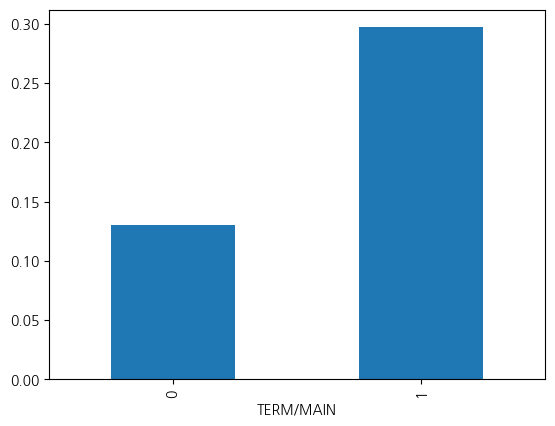

In [27]:
data.groupby('TERM/MAIN').agg('mean')['DELTA_CRDT_GRAD'].plot.bar()

/tmp/ipykernel_7944/2583555613.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('TERM/MAIN').agg('mean')['LTST_CRDT_GRAD'].plot.bar()


<Axes: xlabel='TERM/MAIN'>

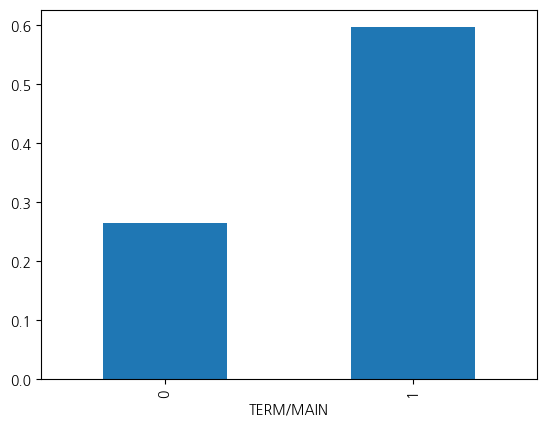

In [28]:
data.groupby('TERM/MAIN').agg('mean')['LTST_CRDT_GRAD'].plot.bar()

/tmp/ipykernel_7944/3842637825.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('TERM/MAIN').agg('mean')['STRT_CRDT_GRAD'].plot.bar()


<Axes: xlabel='TERM/MAIN'>

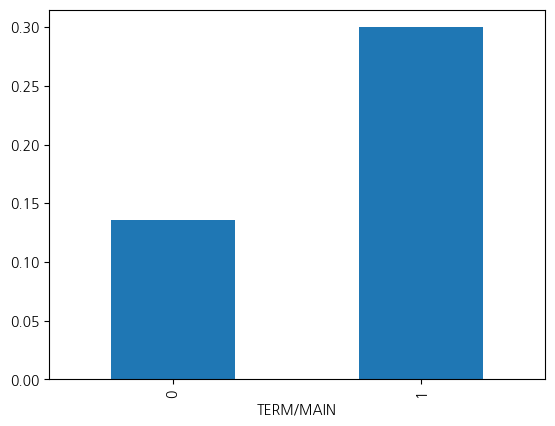

In [29]:
data.groupby('TERM/MAIN').agg('mean')['STRT_CRDT_GRAD'].plot.bar()

- 오래된 신용등급, 최근 신용등급, 신용등급 변화 모두 보험 해지자가 더 높다??

In [30]:
data.groupby('ECT_LNIF_CNT')[['STRT_CRDT_GRAD','LTST_CRDT_GRAD']].mean()

,STRT_CRDT_GRAD,LTST_CRDT_GRAD
ECT_LNIF_CNT,,
0,0.144177,0.265949
1,0.151568,0.313933
2,0.172034,0.412542
3,0.211871,0.512778
4,0.212575,0.461078
5,0.093750,0.203125
6,0.629630,1.370370


In [31]:
# 보장성/저축성 보험 고객 별 특성
# 보장성이나 저축성을 적어도 하나는 가입한 사람
data_GDINS_SVINS = data[(~((data['GDINS_MON_PREM'] == 0) & (data['SVINS_MON_PREM'] == 0)))]
data_NONE = data[((data['GDINS_MON_PREM'] == 0) & (data['SVINS_MON_PREM'] == 0))]

In [32]:
data_GDINS_SVINS

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,양육기,양육기간,TERM/MAIN,양육기2,직업재분류,TOTAL_LOAN_COUNT,TOT_AMT_GRAD,CUST_JOB_INCM_GRAD,AGE_G,DELTA_CRDT_GRAD
0,1,0,1,0,0,0,9001,9001,9001,0,...,0,6.0,0,양육기 후,사무직 및 관리직,1,소,고,50대,0
5,6,0,1,0,1,1,141001,27001,111001,0,...,0,0.0,0,양육기 전,서비스 및 판매직,3,초고,중,40대,0
6,7,0,0,1,2,1,12001,3001,0,9001,...,1,11.0,0,양육기,학생 및 비경제 활동/기타,4,중,소,40대,0
8,9,0,2,0,0,0,273001,273001,273001,0,...,1,21.0,0,양육기,학생 및 비경제 활동/기타,2,초초고,소,40대,0
9,10,0,0,1,1,0,9001,9001,0,9001,...,1,16.0,0,양육기,사무직 및 관리직,2,소,고,40대,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100228,102248,0,1,0,2,2,75001,15001,57001,0,...,0,0.0,0,양육기 후,서비스 및 판매직,5,고,고,50대,0
100229,102249,0,2,0,0,0,54001,9001,54001,0,...,1,11.0,0,양육기,기술직 및 생산직,2,고,중,40대,0
100230,102250,0,1,0,0,0,27001,27001,27001,0,...,1,16.0,0,양육기,서비스 및 판매직,1,중,고,40대,0
100231,102251,0,0,0,1,1,57001,0,0,0,...,0,0.0,0,양육기 전,사무직 및 관리직,2,고,중,40대,0


In [33]:
# 아무것도 가입 안한 사람
data_NONE

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,양육기,양육기간,TERM/MAIN,양육기2,직업재분류,TOTAL_LOAN_COUNT,TOT_AMT_GRAD,CUST_JOB_INCM_GRAD,AGE_G,DELTA_CRDT_GRAD
1,2,0,1,0,0,0,24001,0,24001,0,...,0,1.0,0,양육기 후,서비스 및 판매직,1,중,고,50대,0
2,3,0,0,1,3,2,15001,9001,0,3001,...,0,0.0,0,양육기 후,학생 및 비경제 활동/기타,6,중,소,60대,0
3,4,1,0,2,4,2,6001,3001,0,3001,...,0,0.0,0,양육기 전,학생 및 비경제 활동/기타,8,소,소,30대,0
4,5,0,4,0,0,0,21001,15001,21001,0,...,1,16.0,0,양육기,사무직 및 관리직,4,중,고,40대,0
7,8,0,1,0,0,0,3001,3001,3001,0,...,0,6.0,0,양육기 후,고소득 전문직,1,소,소,60대,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100201,102221,0,1,0,0,0,9001,9001,9001,0,...,0,0.0,0,양육기 전,사무직 및 관리직,1,소,초고,50대,0
100206,102226,0,1,0,1,1,216001,39001,39001,0,...,0,1.0,0,양육기 후,학생 및 비경제 활동/기타,3,초고,소,50대,0
100209,102229,0,1,1,1,0,6001,6001,3001,3001,...,1,11.0,0,양육기,사무직 및 관리직,3,소,고,40대,0
100212,102232,0,0,0,1,1,297001,0,0,0,...,0,0.0,0,양육기 후,학생 및 비경제 활동/기타,2,초초고,소,50대,0


In [34]:
# 보장성 보험만 가입한 사람
data_GDINS = data_GDINS_SVINS[((data_GDINS_SVINS['GDINS_MON_PREM'] != 0) & (data_GDINS_SVINS['SVINS_MON_PREM'] == 0))]
data_GDINS['SVINS_MON_PREM']

0         0
5         0
9         0
10        0
11        0
         ..
100224    0
100226    0
100227    0
100229    0
100231    0
Name: SVINS_MON_PREM, Length: 46082, dtype: int64

In [35]:
#저축성 보험만 가입한 사람
data_SVINS = data_GDINS_SVINS[((data_GDINS_SVINS['GDINS_MON_PREM'] == 0) & (data_GDINS_SVINS['SVINS_MON_PREM'] != 0))]
data_SVINS['GDINS_MON_PREM']

6         0
8         0
20        0
25        0
35        0
         ..
100207    0
100220    0
100225    0
100228    0
100232    0
Name: GDINS_MON_PREM, Length: 12734, dtype: int64

In [36]:
# 둘 다 가입한 사람
data_BOTH = data_GDINS_SVINS[((data_GDINS_SVINS['GDINS_MON_PREM'] != 0) & (data_GDINS_SVINS['SVINS_MON_PREM'] != 0))]
data_BOTH[['GDINS_MON_PREM','SVINS_MON_PREM']]

,GDINS_MON_PREM,SVINS_MON_PREM
18,390000,110000
43,340000,110000
54,1490000,100000
74,150000,490000
80,300000,110000
...,...,...
100202,790000,590000
100213,160000,230000
100217,300000,590000
100221,260000,230000


In [47]:
data_NONE.groupby('직업재분류').mean()

/tmp/ipykernel_7944/4155250952.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_NONE.groupby('직업재분류').mean()


,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,LT1Y_CTLT_CNT,AUTR_FAIL_MCNT,FYCM_PAID_AMT,FMLY_CLAM_CNT,FMLY_PLPY_CNT,양육기,양육기간,TERM/MAIN,TOTAL_LOAN_COUNT,DELTA_CRDT_GRAD
직업재분류,,,,,,,,,,,,,,,,,,,,,
고소득 전문직,51923.015435,0.031805,0.869972,0.483630,0.915341,0.458840,86747.492049,32684.531805,52936.608980,4128.022919,...,0.003274,0.356876,3.119972e+06,2.296539,1.862956,0.158092,2.762395,0.036015,2.727783,0.092142
기술직 및 생산직,51282.545746,0.026752,0.851525,0.486624,0.961477,0.494382,92852.524880,35987.869449,54899.541199,4245.112092,...,0.002943,0.387640,5.094302e+06,4.322365,1.869984,0.174692,3.193151,0.044676,2.794007,0.184591
사무직 및 관리직,51295.579481,0.029209,0.853832,0.507302,0.954858,0.477248,88785.308992,33826.423899,55738.394327,4170.769584,...,0.005914,0.285818,2.725323e+06,2.500302,1.768497,0.158117,2.698008,0.039831,2.793241,0.088835
서비스 및 판매직,51566.885260,0.029788,0.851500,0.463151,0.919462,0.475508,89317.416593,34679.202780,53968.685790,4184.114740,...,0.008164,0.560680,4.746271e+06,3.873786,1.909753,0.146955,2.751324,0.064431,2.709620,0.235216
예체능계 종사자,50335.981221,0.014085,0.830986,0.502347,1.018779,0.553991,85127.760563,36747.201878,44902.051643,3831.314554,...,0.004695,0.183099,5.106103e+06,3.427230,1.826291,0.159624,2.384977,0.051643,2.906103,0.187793
학생 및 비경제 활동/기타,51143.938296,0.028264,0.837400,0.492811,0.955550,0.486238,86982.020458,33624.571276,52832.146989,4198.916112,...,0.004683,0.361351,3.931830e+06,3.219785,1.807575,0.198094,3.456413,0.052502,2.771999,0.156437


/tmp/ipykernel_7944/2756958301.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('AUTR_FAIL_MCNT').mean()['TERM/MAIN'].plot()


<Axes: xlabel='AUTR_FAIL_MCNT'>

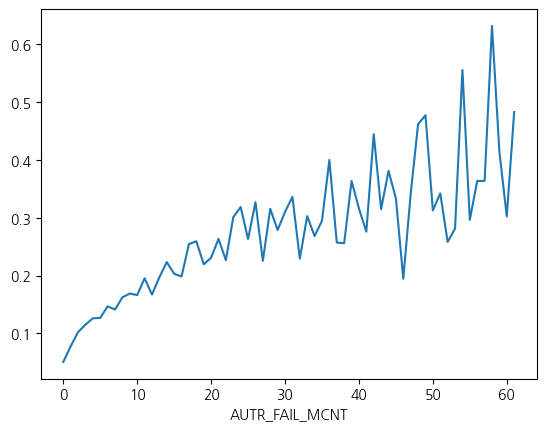

In [51]:
# 자동이체실패월수 별 해지고객 변화

data.groupby('AUTR_FAIL_MCNT').mean()['TERM/MAIN'].plot()

In [76]:
from scipy.stats import f_oneway

# 'data_BOTH'는 직업재분류 및 TARGET 변수를 포함하는 데이터프레임입니다.
# 이 코드에서는 'TARGET'이 종속 변수, '직업재분류'가 독립 변수입니다.

# 각 직업재분류에 따른 'TARGET' 값을 추출
groups = [data_NONE[data_NONE['직업재분류'] == category]['TARGET'] for category in data_NONE['직업재분류'].unique()]

# ANOVA 검정 수행
statistic, p_value = f_oneway(*groups)

# 결과 출력
print("ANOVA Statistic:", statistic)
print("P-value:", p_value)

# P-value를 기반으로 유의수준 0.05에서의 검정 결과 출력
if p_value < 0.05:
    print("평균이 다르다. (귀무가설 기각)")
else:
    print("평균이 같다. (귀무가설 채택)")


ANOVA Statistic: 0.6465147031260315
P-value: 0.6641812465041775
평균이 같다. (귀무가설 채택)


/tmp/ipykernel_7944/3078014222.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_SVINS.groupby('직업재분류').mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='직업재분류'>

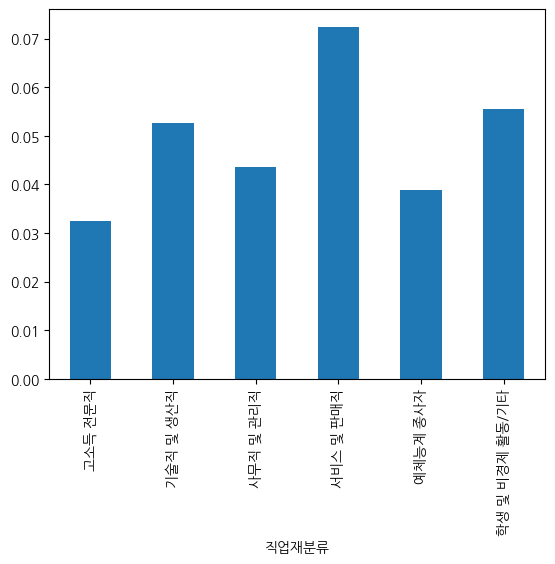

In [77]:
data_SVINS.groupby('직업재분류').mean()['TERM/MAIN'].plot.bar()

In [78]:
groups = [data_SVINS[data_SVINS['직업재분류'] == category]['TARGET'] for category in data_SVINS['직업재분류'].unique()]

# ANOVA 검정 수행
statistic, p_value = f_oneway(*groups)

# 결과 출력
print("ANOVA Statistic:", statistic)
print("P-value:", p_value)

# P-value를 기반으로 유의수준 0.05에서의 검정 결과 출력
if p_value < 0.05:
    print("평균이 다르다. (귀무가설 기각)")
else:
    print("평균이 같다. (귀무가설 채택)")


ANOVA Statistic: 0.8076612423092007
P-value: 0.5439376848398405
평균이 같다. (귀무가설 채택)


/tmp/ipykernel_7944/3429142495.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_SVINS.groupby('AGE_G').mean()['PREM_OVDU_RATE'].plot.bar()


<Axes: xlabel='AGE_G'>

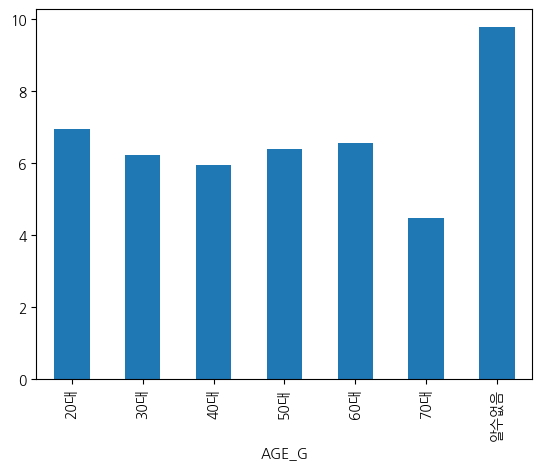

In [79]:
# 저축 보험 가입 연령대별 보험료연체율의 평균
data_SVINS.groupby('AGE_G').mean()['PREM_OVDU_RATE'].plot.bar()

In [80]:
import scipy.stats as stats# 'AGE_G'가 '20대'이고 'CUST_JOB_INCM'이 0이 아닌 데이터 필터링
filtered_data = data_SVINS[data_SVINS['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['CUST_JOB_INCM'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.8743480443954468, p-value = 2.0838271952889932e-19


- 정규성 만족하지 않아서 비모수 검정 시행

In [81]:
# 필터링: CUST_JOB_INCM이 0이 아니고, AGE_G가 '알수없음'이 아닌 데이터만 선택
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['PREM_OVDU_RATE'].values for name, group in filtered_df.groupby('AGE_G') if not group['PREM_OVDU_RATE'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 48.264338561657745, p-value = 3.1368616761469835e-09


- 유의수준이 0.05보다 작으므로 연령별로 보험료연체율의 평균 차이가 존재한다.

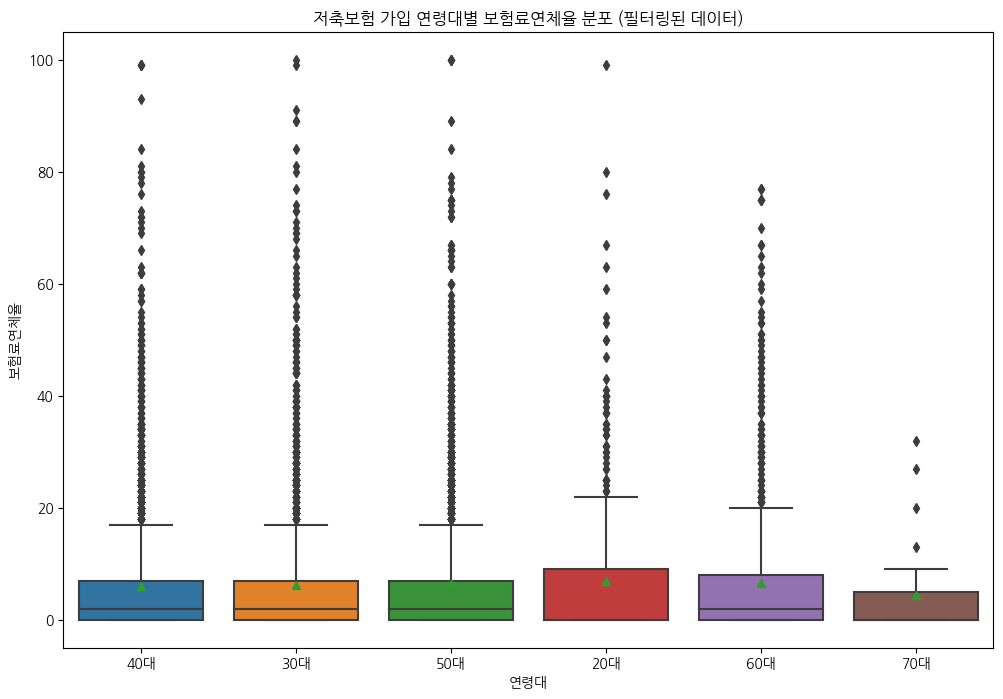

In [82]:
# 필터링: AGE_G가 '알수없음'이 아니고, CUST_JOB_INCM이 0이 아닌 데이터만 선택
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 연령대별 추정소득 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='AGE_G', y='PREM_OVDU_RATE', data=filtered_df, showmeans=True)
plt.title('저축보험 가입 연령대별 보험료연체율 분포 (필터링된 데이터)')
plt.xlabel('연령대')
plt.ylabel('보험료연체율')
plt.show()

- 저축보험 가입 연령대 중 20대의 보험료연체율의 평균이 가장 높았다.
- 다른 연령대에 비해 생계가 불안한 20대를 위해 이자 감면 등 혜택을 통해 저축보험 이탈을 막아야 한다.

/tmp/ipykernel_7944/2109752451.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_GDINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G'>

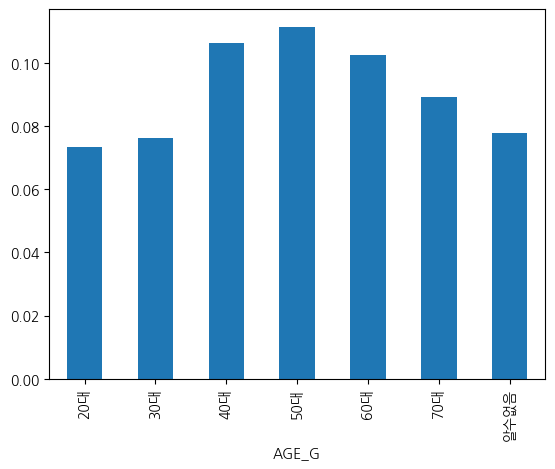

In [83]:
# 보장성 보험 가입 연령대별 해지율의 평균
data_GDINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()

In [84]:
filtered_data = data_GDINS[data_GDINS['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['TERM/MAIN'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.284854531288147, p-value = 0.0


- 정규성 불만족 --> 비모수 검정 수행

In [85]:
filtered_df = data_GDINS[(data_GDINS['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['TERM/MAIN'].values for name, group in filtered_df.groupby('AGE_G') if not group['TERM/MAIN'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 99.84814972711351, p-value = 5.68932434868982e-20


- 유의 수준이 0.05보다 작으므로 보장성 보험 가입 연령대별 해지율의 차이는 존재한다.

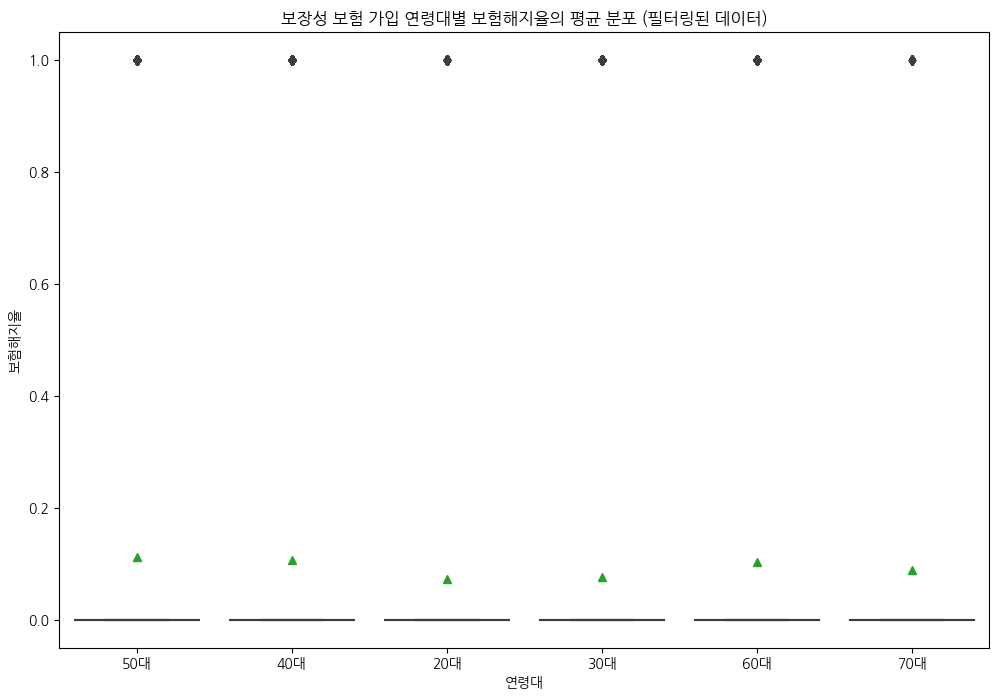

In [86]:
filtered_df = data_GDINS[(data_GDINS['AGE_G'] != '알수없음')]# 연령대별 추정소득 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='AGE_G', y='TERM/MAIN', data=filtered_df, showmeans=True)
plt.title('보장성 보험 가입 연령대별 보험해지율의 평균 분포 (필터링된 데이터)')
plt.xlabel('연령대')
plt.ylabel('보험해지율')
plt.show()

- 405060대 보장성 보험 가입자의 보험 해지율의 평균이 2030보다 높았다.
- 2030보다 405060의 보험 해지율의 평균이 높은 원인을 찾아보고 싶다.
- 양육기의 차이로 검정

In [87]:
# 'AGE_G'가 '40대', '50대', '60대' 중 하나인 행 선택
new_data_GDINS = data_GDINS[data_GDINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]

# 결과 출력
print(new_data_GDINS)


        CUST_ID  TARGET  BNK_LNIF_CNT  CPT_LNIF_CNT  SPART_LNIF_CNT  \
0             1       0             1             0               0   
5             6       0             1             0               1   
9            10       0             0             1               1   
10           11       1             0             3               5   
11           12       0             0             1               2   
...         ...     ...           ...           ...             ...   
100223   102243       0             3             1               1   
100224   102244       0             0             2               4   
100227   102247       0             2             0               0   
100229   102249       0             2             0               0   
100231   102251       0             0             0               1   

        ECT_LNIF_CNT  TOT_LNIF_AMT  TOT_CLIF_AMT  BNK_LNIF_AMT  CPT_LNIF_AMT  \
0                  0          9001          9001          9001     

/tmp/ipykernel_7944/2950090920.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS.groupby(['AGE_G','양육기']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,양육기'>

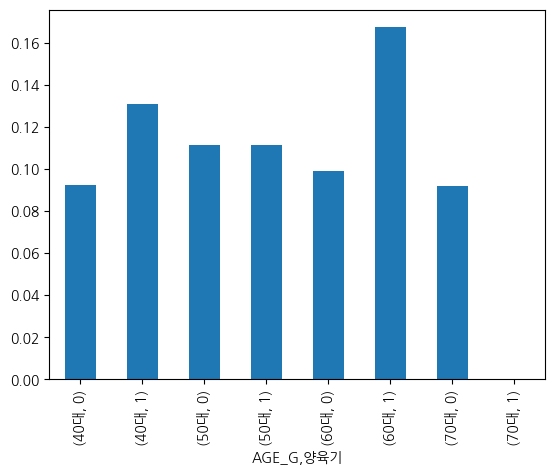

In [88]:
new_data_GDINS.groupby(['AGE_G','양육기']).mean()['TERM/MAIN'].plot.bar()

In [90]:
data_GDINS_해지 = data_GDINS[data_GDINS['TERM/MAIN'] == 1]
data_GDINS_해지['TERM/MAIN']

46        1
68        1
119       1
156       1
190       1
         ..
100132    1
100134    1
100149    1
100198    1
100208    1
Name: TERM/MAIN, Length: 4609, dtype: int64

In [91]:
new_data_GDINS_해지 = data_GDINS_해지[data_GDINS_해지['AGE_G'].isin(['40대', '50대', '60대','70대'])]

In [92]:
# 카이제곱 검정 수행
cross_tab = pd.crosstab(new_data_GDINS_해지['AGE_G'], new_data_GDINS_해지['양육기'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 517.3877988043362
p-값: 8.134898129606897e-112
자유도: 3
기대 빈도: [[1171.87739872  400.12260128]
 [1196.47787846  408.52212154]
 [ 418.20815565  142.79184435]
 [  10.43656716    3.56343284]]


- 유의수준이 0.05보다 작으므로 보장성 보험 해지 고객 중에서 양육기 자녀 유무에 따라 보험해지에 차이가 있다 : 대립가설


In [93]:
new_data_GDINS2 = data_GDINS[data_GDINS['AGE_G'].isin(['20대', '30대'])]

In [94]:
new_data_GDINS2.groupby(['AGE_G','양육기'])['TERM/MAIN'].mean()

AGE_G  양육기
20대    0      0.070629
       1      0.113402
30대    0      0.067078
       1      0.121622
Name: TERM/MAIN, dtype: float64

/tmp/ipykernel_7944/3797385406.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS2.groupby(['AGE_G','양육기']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,양육기'>

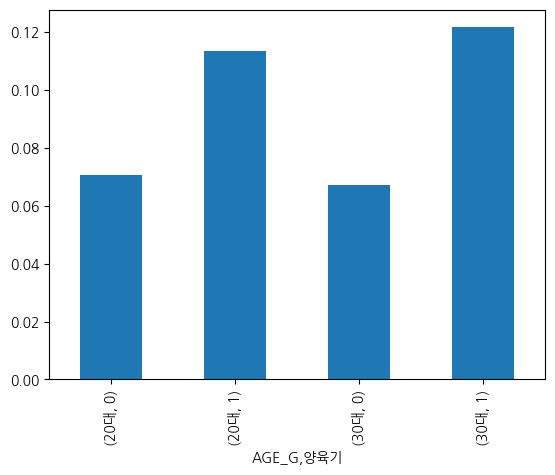

In [95]:
new_data_GDINS2.groupby(['AGE_G','양육기']).mean()['TERM/MAIN'].plot.bar()

In [96]:
new_data_GDINS_해지2 = new_data_GDINS2[new_data_GDINS2['TERM/MAIN'] == 1]
new_data_GDINS_해지2['TERM/MAIN']

210       1
550       1
622       1
684       1
967       1
         ..
99576     1
99640     1
99983     1
100093    1
100134    1
Name: TERM/MAIN, Length: 843, dtype: int64

In [97]:
cross_tab = pd.crosstab(new_data_GDINS_해지2['AGE_G'], new_data_GDINS_해지2['양육기'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 14.613466647827781
p-값: 0.00013196812784483516
자유도: 1
기대 빈도: [[ 84.23250297  27.76749703]
 [549.76749703 181.23250297]]


- 유의수준이 0.05보다 작으므로 2030도 양육기 자녀의 유무에 따라 보험해지수준에 차이가 있다.

In [98]:
data_GDINS['AGE_G_NEW/OLD'] = ''
data_GDINS.loc[data_GDINS['AGE_G'].isin(['20대', '30대']) == True, 'AGE_G_NEW/OLD'] = "NEW"
data_GDINS.loc[data_GDINS['AGE_G'].isin(['40대', '50대', '60대']) == True, 'AGE_G_NEW/OLD'] = "OLD"

/tmp/ipykernel_7944/3271255142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_GDINS['AGE_G_NEW/OLD'] = ''


In [99]:
data_GDINS['AGE_G_NEW/OLD'].value_counts()

OLD    34644
NEW    11101
         337
Name: AGE_G_NEW/OLD, dtype: int64

In [100]:
new_data_GDINS_해지3 = data_GDINS[data_GDINS['TERM/MAIN'] == 1]
new_data_GDINS_해지3['TERM/MAIN']

46        1
68        1
119       1
156       1
190       1
         ..
100132    1
100134    1
100149    1
100198    1
100208    1
Name: TERM/MAIN, Length: 4609, dtype: int64

In [101]:
cross_tab = pd.crosstab(new_data_GDINS_해지3['AGE_G_NEW/OLD'], new_data_GDINS_해지3['양육기'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 2.027868640487352
p-값: 0.36278884062411504
자유도: 2
기대 빈도: [[  20.90431764    7.09568236]
 [ 629.3692775   213.6307225 ]
 [2790.72640486  947.27359514]]


/tmp/ipykernel_7944/833797678.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_SVINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G'>

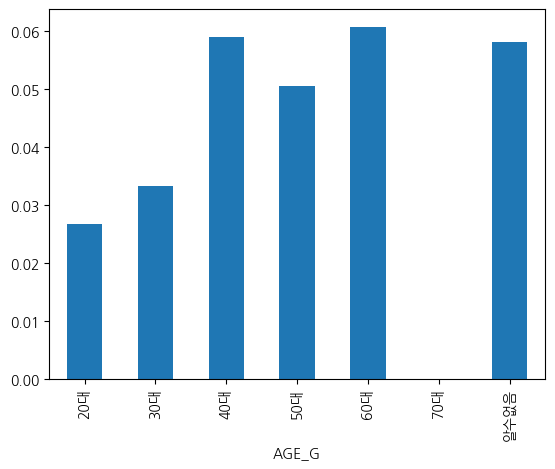

In [102]:
# 저축성 보험 가입 고객 연령별 보험해지율의 차이
data_SVINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()

In [103]:
filtered_data = data_SVINS[data_SVINS['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['TERM/MAIN'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.14680391550064087, p-value = 5.0993251116780093e-42


- 정규성 불만족

In [104]:
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['TERM/MAIN'].values for name, group in filtered_df.groupby('AGE_G') if not group['TERM/MAIN'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 33.589762371336455, p-value = 2.873342565988349e-06


- 저축성 보험 가입자 연령별 보험해지율의 차이는 존재한다.

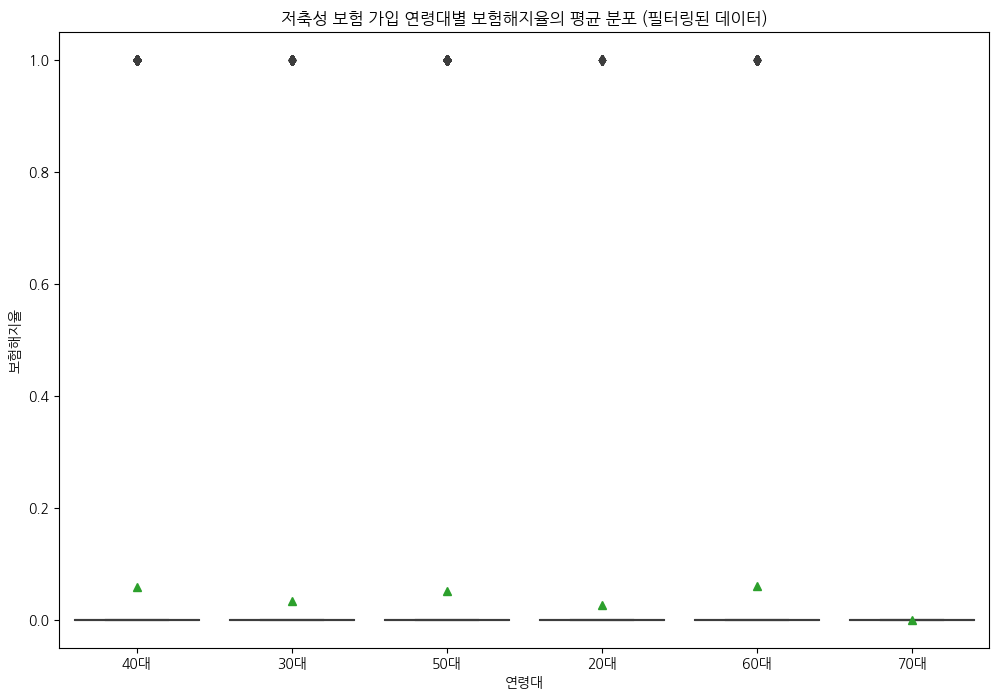

In [105]:
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 연령대별 추정소득 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='AGE_G', y='TERM/MAIN', data=filtered_df, showmeans=True)
plt.title('저축성 보험 가입 연령대별 보험해지율의 평균 분포 (필터링된 데이터)')
plt.xlabel('연령대')
plt.ylabel('보험해지율')
plt.show()

In [106]:
new_data_SVINS = data_SVINS[data_SVINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]

<Axes: xlabel='AGE_G,양육기'>

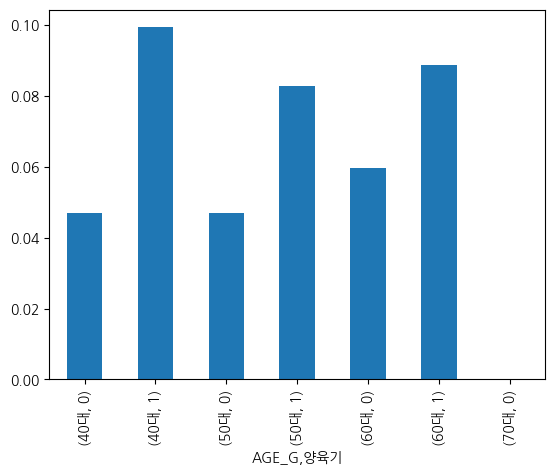

In [107]:
new_data_SVINS.groupby(['AGE_G','양육기'])['TERM/MAIN'].mean().plot.bar()

In [108]:
data_SVINS_해지 = data_SVINS[data_SVINS['TERM/MAIN'] == 1]
data_SVINS_해지['TERM/MAIN']

242       1
276       1
603       1
607       1
680       1
         ..
99866     1
99977     1
100021    1
100172    1
100205    1
Name: TERM/MAIN, Length: 631, dtype: int64

In [109]:
new_data_SVINS_해지 = data_SVINS_해지[data_SVINS_해지['AGE_G'].isin(['40대', '50대', '60대','70대'])]

In [110]:
cross_tab = pd.crosstab(new_data_SVINS_해지['AGE_G'], new_data_SVINS_해지['양육기'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 48.0355332503422
p-값: 3.7086554471451744e-11
자유도: 2
기대 빈도: [[181.84703633  60.15296367]
 [153.29254302  50.70745698]
 [ 57.86042065  19.13957935]]


- 유의수준이 0.05보다 작으므로 저축성 보험 해지 고객 중에서 양육기 자녀 유무에 따라 보험해지에 차이가 있다 : 대립가성

/tmp/ipykernel_7944/2109752451.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_GDINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G'>

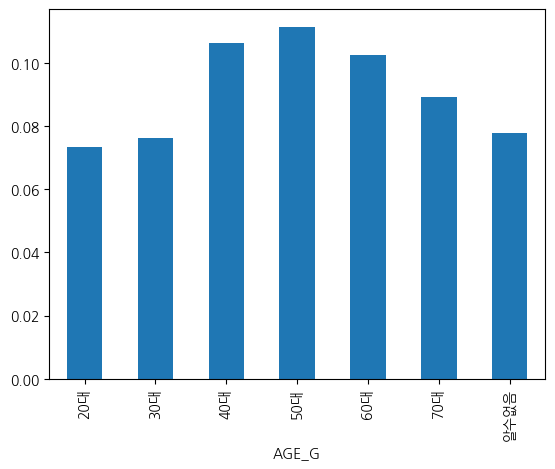

In [120]:
# 보장성 보험 가입 연령대별 해지율의 평균
data_GDINS.groupby('AGE_G').mean()['TERM/MAIN'].plot.bar()

In [121]:
filtered_data = data_GDINS[data_GDINS['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['TERM/MAIN'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.284854531288147, p-value = 0.0


In [122]:
filtered_df = data_GDINS[(data_GDINS['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['TERM/MAIN'].values for name, group in filtered_df.groupby('AGE_G') if not group['TERM/MAIN'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 99.84814972711351, p-value = 5.68932434868982e-20


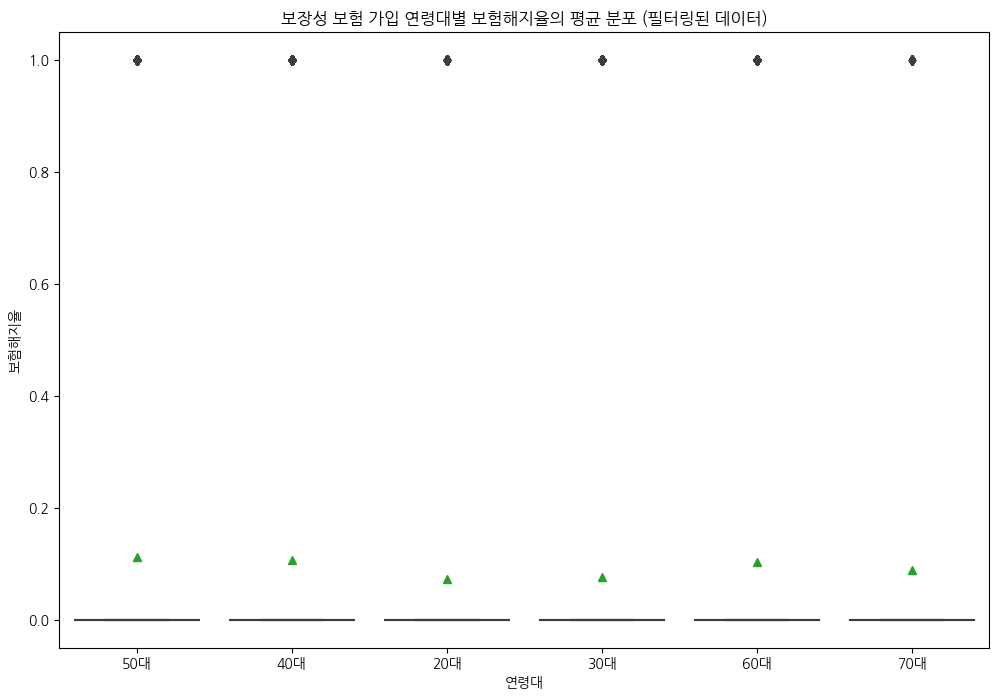

In [123]:
filtered_df = data_GDINS[(data_GDINS['AGE_G'] != '알수없음')]# 연령대별 추정소득 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='AGE_G', y='TERM/MAIN', data=filtered_df, showmeans=True)
plt.title('보장성 보험 가입 연령대별 보험해지율의 평균 분포 (필터링된 데이터)')
plt.xlabel('연령대')
plt.ylabel('보험해지율')
plt.show()

In [124]:
data_GDINS_해지 = data_GDINS[data_GDINS['TERM/MAIN'] == 1]
data_GDINS_해지['TERM/MAIN']

46        1
68        1
119       1
156       1
190       1
         ..
100132    1
100134    1
100149    1
100198    1
100208    1
Name: TERM/MAIN, Length: 4609, dtype: int64

In [444]:
new_data_GDINS = data_GDINS[data_GDINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]
new_data_GDINS2 = data_GDINS[data_GDINS['AGE_G'].isin(['20대', '30대'])]

In [448]:
new_data_SVINS = data_SVINS[data_SVINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]

/tmp/ipykernel_7944/2455935058.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_SVINS.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,양육기2'>

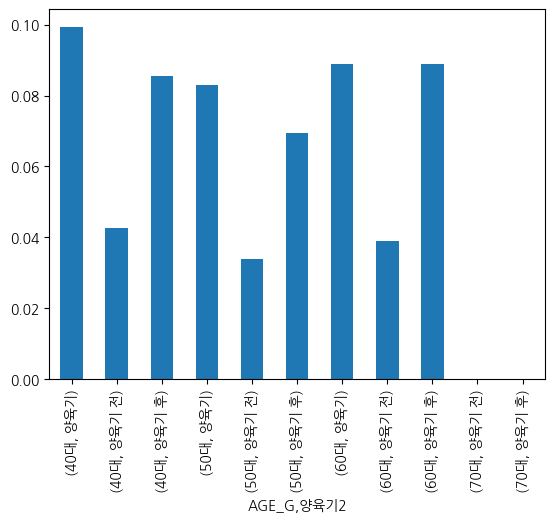

In [449]:
new_data_SVINS.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()

/tmp/ipykernel_7944/3803724191.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,양육기2'>

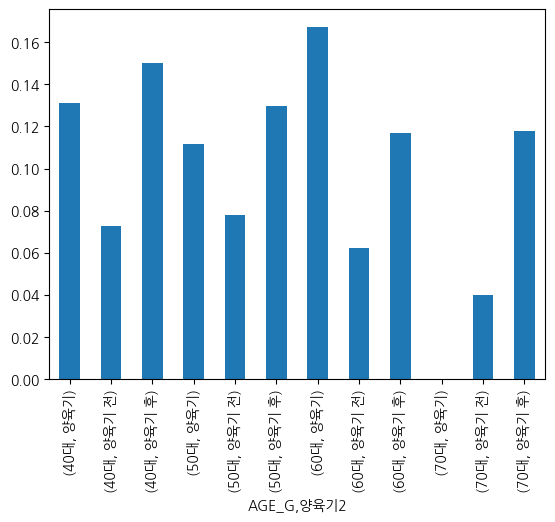

In [126]:
new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()

In [458]:
new_data_GDINS.groupby(['AGE_G','양육기2'])['TERM/MAIN'].value_counts()

AGE_G  양육기2   TERM/MAIN
40대    양육기    0            4630
              1             698
       양육기 전  0            6526
              1             511
       양육기 후  0            2055
              1             363
50대    양육기    0            1665
              1             209
       양육기 전  0            4010
              1             338
       양육기 후  0            7113
              1            1058
60대    양육기    0             239
              1              48
       양육기 전  0            1587
              1             105
       양육기 후  0            3081
              1             408
70대    양육기    0               5
       양육기 전  0              48
              1               2
       양육기 후  0              90
              1              12
Name: TERM/MAIN, dtype: int64

/tmp/ipykernel_7944/3546334288.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS2.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,양육기2'>

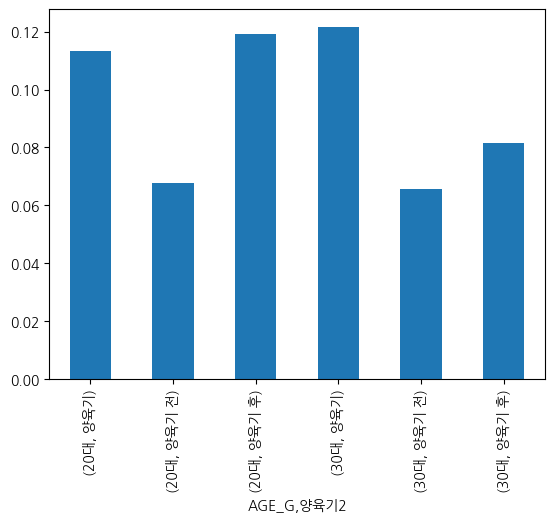

In [445]:
new_data_GDINS2.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()

In [446]:
cross_tab = pd.crosstab(new_data_GDINS_해지['AGE_G'], new_data_GDINS_해지['양육기2'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 816.1224899755969
p-값: 5.0559444605601584e-173
자유도: 6
기대 빈도: [[400.12260128 400.54157783 771.3358209 ]
 [408.52212154 408.94989339 787.52798507]
 [142.79184435 142.94136461 275.26679104]
 [  3.56343284   3.56716418   6.86940299]]


In [447]:
cross_tab

양육기2,양육기,양육기 전,양육기 후
AGE_G,,,
40대,698,511,363
50대,209,338,1058
60대,48,105,408
70대,0,2,12


- 보장성 보험을 해지한 40506070 고객중 양육기 자녀에 따라 보험해지율 평균에 차이가 존재한다.
- 모든 세대에서 양육기 후 자녀를 가진 고객들은 해지율이 증가한다.
- 이 고객들을 자녀에게 큰돈이 들어갈 일이 적고 노후 대비가 필요하므로 저축성 보험, 연금 보험 가입 권유 등 마케팅 전략이 필요하다.

- 귀무가설: 보장성 보험을 해지한 40~70 고객 연령별로 양육기 자녀의 나이에 따른 보험해지율 차이는 없다
- 대립가설: 보장성 보험을 해지한 40~70 고객 연령별로 양육기 자녀의 나이에 따른 보험해지율 차이가 있다.

In [411]:
data_SVINS['AGE_G'].value_counts()

40대     4109
50대     4039
30대     2714
60대     1268
20대      487
알수없음      86
70대       31
Name: AGE_G, dtype: int64

In [415]:
new_data_SVINS = data_SVINS[data_SVINS['AGE_G'].isin(['30대','40대', '50대'])]
new_data_SVINS['AGE_G'].value_counts()

40대    4109
50대    4039
30대    2714
Name: AGE_G, dtype: int64

In [423]:
cross_tab = pd.crosstab(new_data_SVINS['직업재분류'], new_data_SVINS['TERM/MAIN'])
cross_tab

TERM/MAIN,0,1
직업재분류,,
고소득 전문직,1376,44
기술직 및 생산직,1053,61
사무직 및 관리직,4171,185
서비스 및 판매직,1179,97
예체능계 종사자,90,2
학생 및 비경제 활동/기타,2457,147


In [437]:
cross_tab.T

직업재분류,고소득 전문직,기술직 및 생산직,사무직 및 관리직,서비스 및 판매직,예체능계 종사자,학생 및 비경제 활동/기타
TERM/MAIN,,,,,,
0,1376.000000,1053.000000,4171.000000,1179.000000,90.000000,2457.000000
1,44.000000,61.000000,185.000000,97.000000,2.000000,147.000000
rate,3.098592,5.475763,4.247016,7.601881,2.173913,5.645161


In [424]:
cross_tab['rate'] = cross_tab[1] / (cross_tab[0] + cross_tab[1]) * 100
cross_tab

TERM/MAIN,0,1,rate
직업재분류,,,
고소득 전문직,1376,44,3.098592
기술직 및 생산직,1053,61,5.475763
사무직 및 관리직,4171,185,4.247016
서비스 및 판매직,1179,97,7.601881
예체능계 종사자,90,2,2.173913
학생 및 비경제 활동/기타,2457,147,5.645161


In [417]:

chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 38.93782758145912
p-값: 2.444256886737312e-07
자유도: 5
기대 빈도: [[1349.92819002 1059.02817161 4141.04732094 1213.03406371   87.46013625
  2475.50211747]
 [  70.07180998   54.97182839  214.95267906   62.96593629    4.53986375
   128.49788253]]


<Axes: xlabel='직업재분류'>

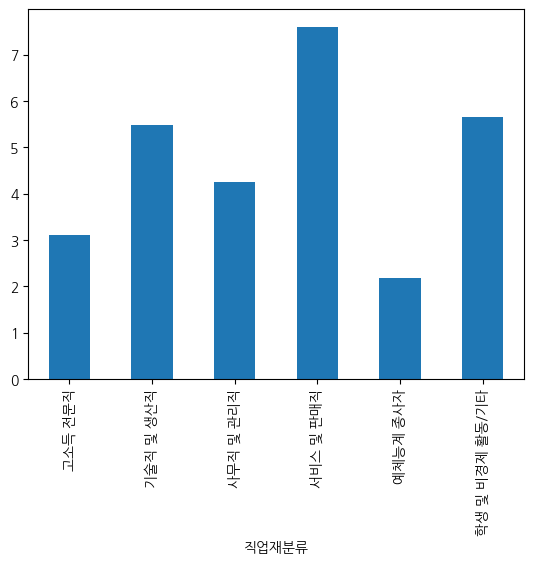

In [427]:
cross_tab['rate'].plot.bar()

In [428]:
new_data_SVINS = data_SVINS[data_SVINS['AGE_G'].isin(['30대','40대', '50대'])]
new_data_SVINS['AGE_G'].value_counts()

40대    4109
50대    4039
30대    2714
Name: AGE_G, dtype: int64

In [ ]:
data_SVINS[data_SVINS['직업재분류'] == "서비스 및 판매직"]

<Axes: xlabel='직업재분류'>

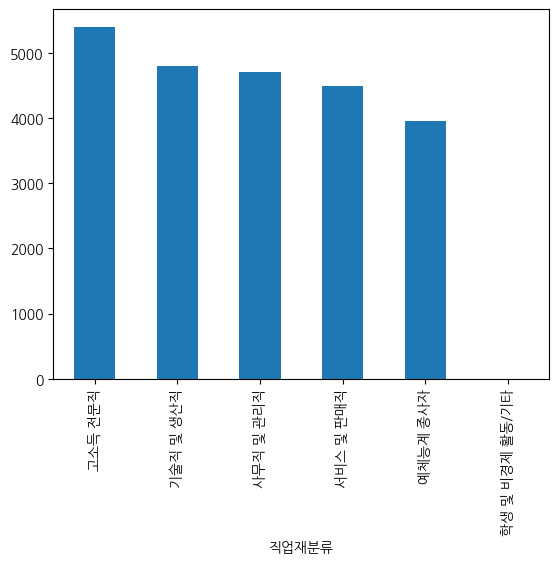

In [436]:
new_data_SVINS.groupby('직업재분류')['CUST_JOB_INCM'].median().plot.bar()

<Axes: xlabel='직업재분류'>

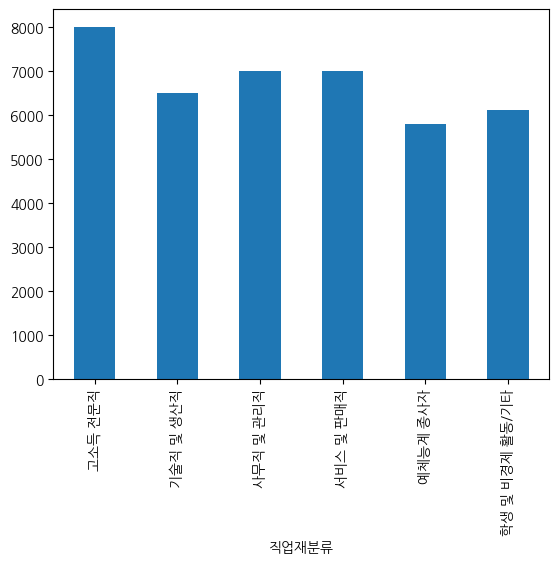

In [438]:
new_data_SVINS.groupby('직업재분류')['HSHD_INFR_INCM'].median().plot.bar()

<Axes: xlabel='직업재분류'>

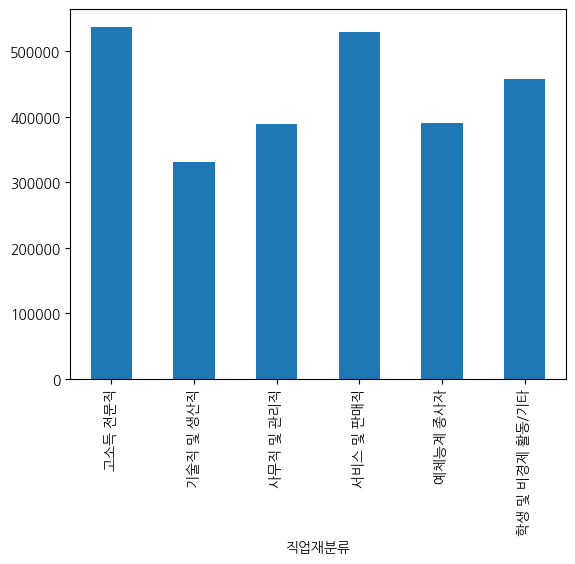

In [439]:
new_data_SVINS.groupby('직업재분류')['MAX_MON_PREM'].mean().plot.bar()

<Axes: xlabel='직업재분류'>

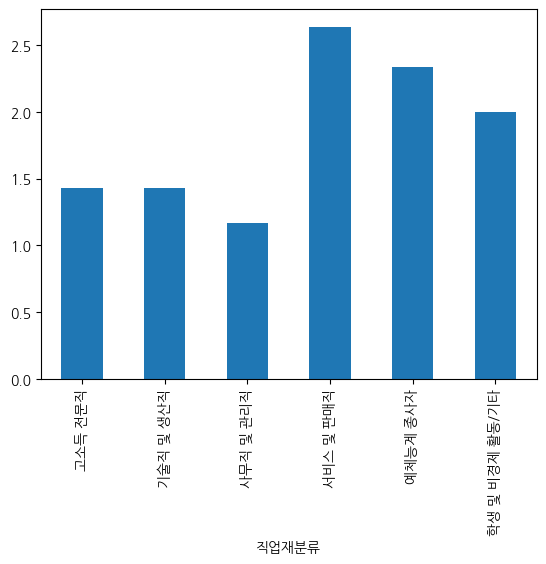

In [442]:
new_data_SVINS.groupby('직업재분류')['AUTR_FAIL_MCNT'].mean().plot.bar()

<Axes: xlabel='직업재분류'>

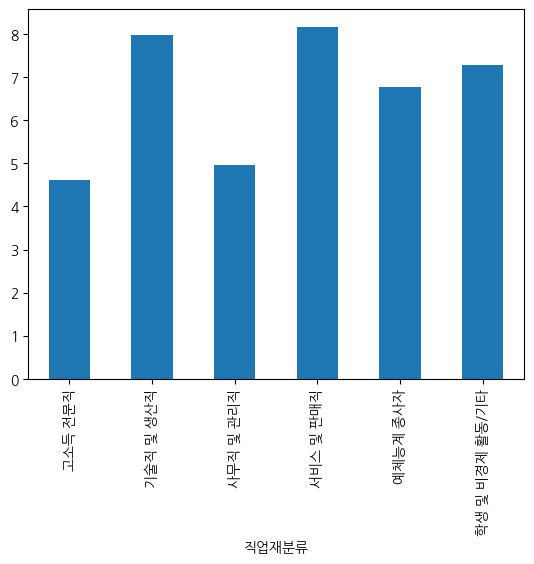

In [443]:
new_data_SVINS.groupby('직업재분류')['PREM_OVDU_RATE'].mean().plot.bar()

/tmp/ipykernel_7944/907604841.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_SVINS.groupby(['AGE_G','직업재분류']).mean()['TERM/MAIN'].plot.bar()


<Axes: xlabel='AGE_G,직업재분류'>

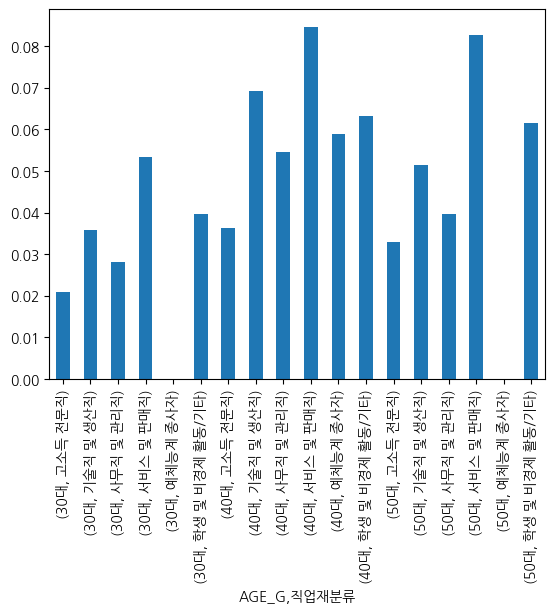

In [398]:
new_data_SVINS.groupby(['AGE_G','직업재분류']).mean()['TERM/MAIN'].plot.bar()

In [399]:
data_SVINS_해지 = data_SVINS[data_SVINS['TERM/MAIN'] == 1]
data_SVINS_해지['TERM/MAIN']

242       1
276       1
603       1
607       1
680       1
         ..
99866     1
99977     1
100021    1
100172    1
100205    1
Name: TERM/MAIN, Length: 631, dtype: int64

In [408]:
new_data_SVINS_해지 = data_SVINS_해지[data_SVINS_해지['AGE_G'].isin(['30대', '40대', '50대'])]

In [409]:
new_data_SVINS_해지

,CUST_ID,TARGET,BNK_LNIF_CNT,CPT_LNIF_CNT,SPART_LNIF_CNT,ECT_LNIF_CNT,TOT_LNIF_AMT,TOT_CLIF_AMT,BNK_LNIF_AMT,CPT_LNIF_AMT,...,양육기,양육기간,TERM/MAIN,양육기2,직업재분류,TOTAL_LOAN_COUNT,TOT_AMT_GRAD,CUST_JOB_INCM_GRAD,AGE_G,DELTA_CRDT_GRAD
242,245,0,1,0,0,0,24001,24001,24001,0,...,0,6.0,1,양육기 후,서비스 및 판매직,1,중,중,50대,0
603,611,0,1,0,0,0,6001,6001,6001,0,...,0,1.0,1,양육기 후,사무직 및 관리직,1,소,고,40대,0
607,615,0,0,1,2,1,33001,27001,0,3001,...,0,0.0,1,양육기 전,학생 및 비경제 활동/기타,4,중,소,30대,0
680,689,0,1,0,1,1,54001,18001,33001,0,...,1,16.0,1,양육기,서비스 및 판매직,3,고,중,30대,0
987,1007,0,1,1,1,0,225001,225001,198001,27001,...,0,0.0,1,양육기 전,사무직 및 관리직,3,초고,중,40대,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99864,101876,1,0,0,1,1,1,1,0,0,...,1,17.6,1,양육기,학생 및 비경제 활동/기타,2,소,초고,40대,0
99866,101878,0,1,0,0,0,3001,3001,3001,0,...,0,6.0,1,양육기 후,기술직 및 생산직,1,소,중,40대,0
99977,101992,0,1,0,0,0,15001,0,15001,0,...,0,0.0,1,양육기 후,학생 및 비경제 활동/기타,1,중,소,50대,0
100172,102191,0,1,0,0,0,198001,198001,198001,0,...,0,0.0,1,양육기 전,고소득 전문직,1,초고,초고,40대,0


In [406]:
cross_tab = pd.crosstab(new_data_GDINS_해지['AGE_G'], new_data_GDINS_해지['직업재분류'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 99.55652627749362
p-값: 1.5832135862838228e-14
자유도: 15
기대 빈도: [[6.49413646e+01 2.06136461e+02 2.53061834e+02 4.32383795e+02
  1.59211087e+01 5.99555437e+02]
 [6.63046375e+01 2.10463753e+02 2.58374200e+02 4.41460554e+02
  1.62553305e+01 6.12141525e+02]
 [2.31756397e+01 7.35639659e+01 9.03102345e+01 1.54304904e+02
  5.68176972e+00 2.13963486e+02]
 [5.78358209e-01 1.83582090e+00 2.25373134e+00 3.85074627e+00
  1.41791045e-01 5.33955224e+00]]


In [403]:
cross_tab = pd.crosstab(new_data_GDINS_해지['AGE_G'], new_data_GDINS_해지['직업재분류'])

In [404]:
cross_tab

직업재분류,고소득 전문직,기술직 및 생산직,사무직 및 관리직,서비스 및 판매직,예체능계 종사자,학생 및 비경제 활동/기타
AGE_G,,,,,,
40대,87,196,326,383,19,561
50대,52,230,223,495,16,589
60대,16,66,52,153,3,271
70대,0,0,3,1,0,10


<Axes: xlabel='AGE_G'>

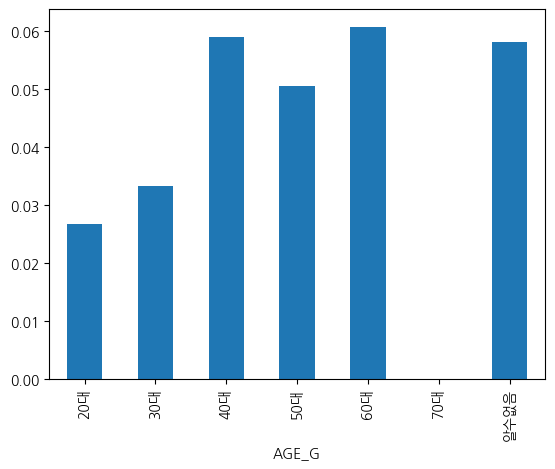

In [128]:
# 저축성 보험 가입 고객 연령별 보험해지율의 차이
data_SVINS.groupby('AGE_G')['TERM/MAIN'].mean().plot.bar()

In [129]:
filtered_data = data_SVINS[data_SVINS['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['TERM/MAIN'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.14680391550064087, p-value = 5.0993251116780093e-42


In [130]:
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['TERM/MAIN'].values for name, group in filtered_df.groupby('AGE_G') if not group['TERM/MAIN'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 33.589762371336455, p-value = 2.873342565988349e-06


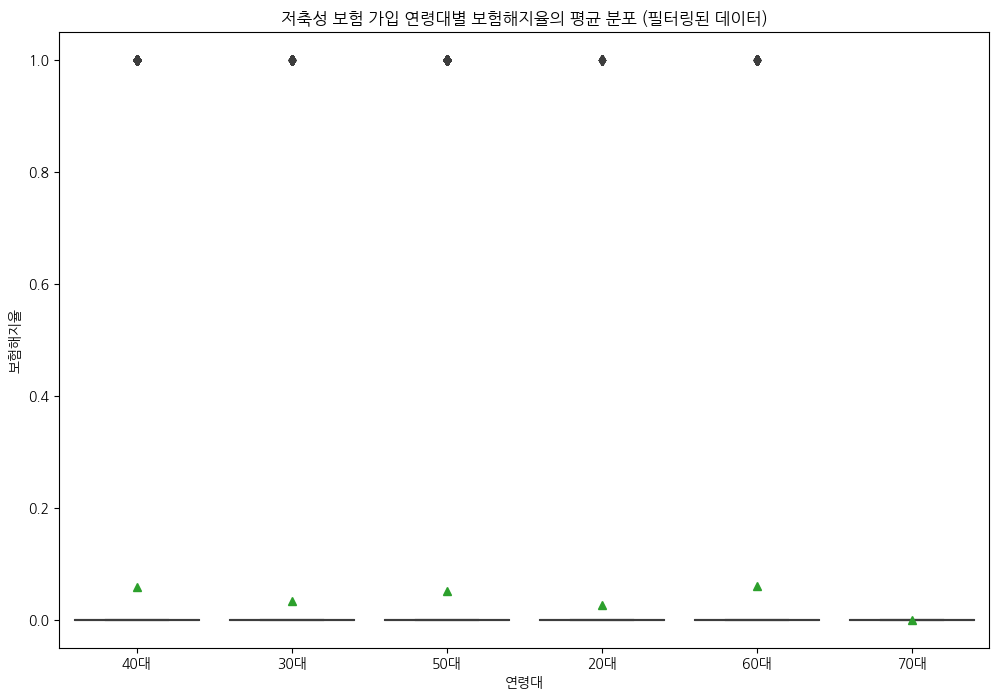

In [131]:
filtered_df = data_SVINS[(data_SVINS['AGE_G'] != '알수없음')]# 연령대별 추정소득 박스플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='AGE_G', y='TERM/MAIN', data=filtered_df, showmeans=True)
plt.title('저축성 보험 가입 연령대별 보험해지율의 평균 분포 (필터링된 데이터)')
plt.xlabel('연령대')
plt.ylabel('보험해지율')
plt.show()

In [132]:
new_data_SVINS = data_SVINS[data_SVINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]

<Axes: xlabel='AGE_G,양육기2'>

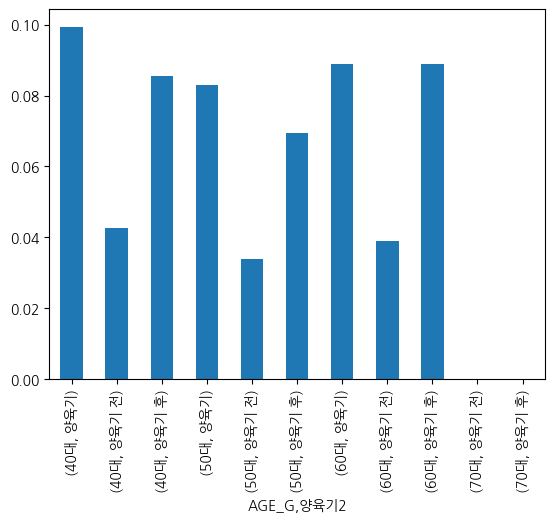

In [133]:
new_data_SVINS.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean().plot.bar()

In [134]:
data_SVINS_해지 = data_SVINS[data_SVINS['TERM/MAIN'] == 1]
data_SVINS_해지['TERM/MAIN']

242       1
276       1
603       1
607       1
680       1
         ..
99866     1
99977     1
100021    1
100172    1
100205    1
Name: TERM/MAIN, Length: 631, dtype: int64

In [135]:
new_data_SVINS_해지 = data_SVINS_해지[data_SVINS_해지['AGE_G'].isin(['40대', '50대', '60대','70대'])]

In [136]:
cross_tab = pd.crosstab(new_data_SVINS_해지['AGE_G'], new_data_SVINS_해지['양육기2'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 101.29625102142488
p-값: 5.2101849018012084e-21
자유도: 4
기대 빈도: [[ 60.15296367 105.03632887  76.81070746]
 [ 50.70745698  88.54302103  64.74952199]
 [ 19.13957935  33.4206501   24.43977055]]


- 모든 세대에서 양육기인 자녀를 키우는데 돈이 많이 들어서 저축성 보험 해지율이 증가한다고 생각한다.

<Axes: xlabel='AGE_G'>

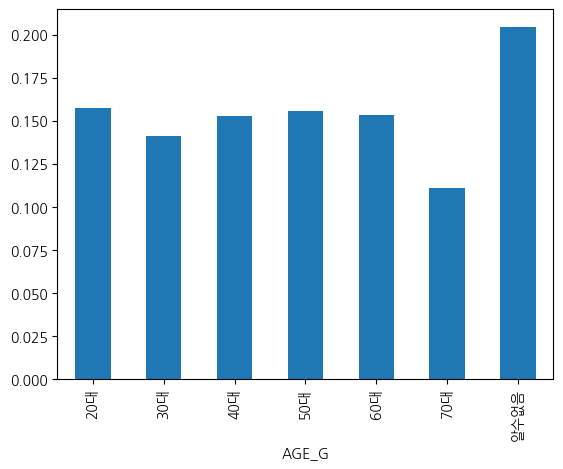

In [137]:
# 보장성&저축성 보험 가입 고객 연령별 보험해지율의 차이
data_BOTH.groupby('AGE_G')['TERM/MAIN'].mean().plot.bar()

In [138]:
filtered_data = data_BOTH[data_BOTH['AGE_G'] == '20대']# Shapiro-Wilk 검정 수행
statistic, p = stats.shapiro(filtered_data['TERM/MAIN'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.43636757135391235, p-value = 1.440690089339549e-29


In [139]:
filtered_df = data_BOTH[(data_BOTH['AGE_G'] != '알수없음')]# 'AGE_G'별로 'CUST_JOB_INCM' 데이터를 그룹화
groups = [group['TERM/MAIN'].values for name, group in filtered_df.groupby('AGE_G') if not group['TERM/MAIN'].empty]# Kruskal-Wallis H-test (비모수 검정) 수행
statistic, p = stats.kruskal(*groups)
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 2.729273230009895, p-value = 0.741637714994938


In [140]:
new_data_BOTH = data_BOTH[data_BOTH['AGE_G'].isin(['40대', '50대', '60대', '70대'])]

<Axes: xlabel='AGE_G,양육기2'>

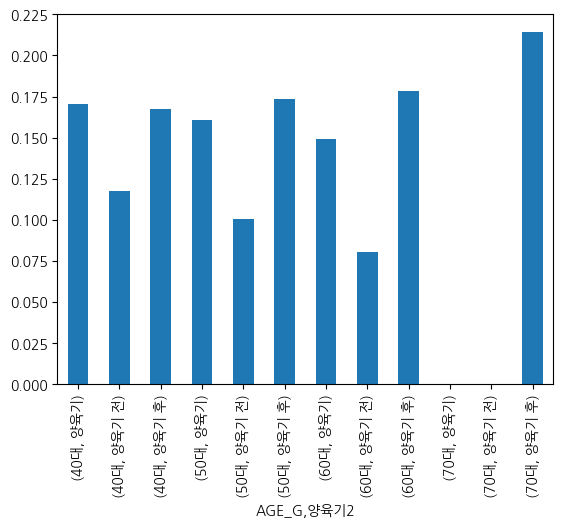

In [141]:
new_data_BOTH.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean().plot.bar()

In [142]:
data_BOTH_해지 = data_BOTH[data_BOTH['TERM/MAIN'] == 1]
data_BOTH_해지['TERM/MAIN']

43        1
54        1
96        1
129       1
132       1
         ..
99812     1
99845     1
100064    1
100074    1
100213    1
Name: TERM/MAIN, Length: 1567, dtype: int64

In [143]:
new_data_BOTH_해지 = data_BOTH_해지[data_BOTH_해지['AGE_G'].isin(['40대', '50대', '60대','70대'])]

In [144]:
cross_tab = pd.crosstab(new_data_BOTH_해지['AGE_G'], new_data_BOTH_해지['양육기2'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 351.5171116483002
p-값: 7.290777620727943e-73
자유도: 6
기대 빈도: [[180.58162428  98.81706317 253.60131255]
 [180.58162428  98.81706317 253.60131255]
 [ 50.82034454  27.80968007  71.36997539]
 [  1.01640689   0.5561936    1.42739951]]


In [145]:
new_data_SVINS2 = data_SVINS[data_SVINS['AGE_G'].isin(['20대', '30대'])]

In [146]:
new_data_SVINS2.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean()

AGE_G  양육기2 
20대    양육기      0.071429
       양육기 전    0.021930
       양육기 후    0.117647
30대    양육기      0.063830
       양육기 전    0.027073
       양육기 후    0.095652
Name: TERM/MAIN, dtype: float64

<Axes: xlabel='AGE_G,양육기2'>

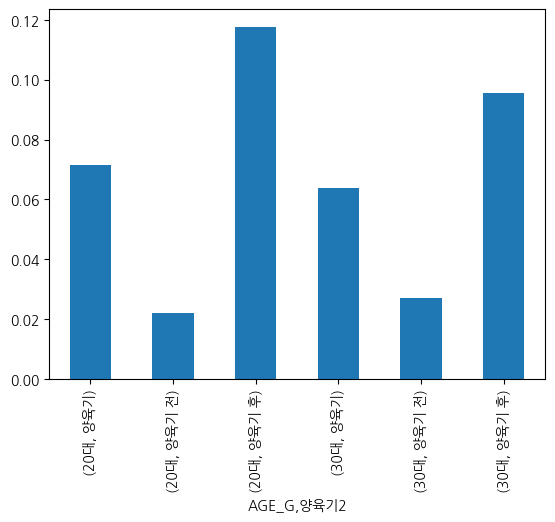

In [147]:
new_data_SVINS2.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean().plot.bar()

In [148]:
new_data_SVINS_해지2 = new_data_SVINS2[new_data_SVINS2['TERM/MAIN'] == 1]
new_data_SVINS_해지2['TERM/MAIN']

607       1
680       1
1913      1
2430      1
7860      1
         ..
97868     1
97885     1
97951     1
98019     1
100205    1
Name: TERM/MAIN, Length: 103, dtype: int64

In [149]:
cross_tab = pd.crosstab(new_data_SVINS_해지2['AGE_G'], new_data_SVINS_해지2['양육기2'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 0.7323561357215205
p-값: 0.6933793216437105
자유도: 2
기대 빈도: [[ 2.01941748  9.33980583  1.6407767 ]
 [13.98058252 64.66019417 11.3592233 ]]


In [150]:
new_data_GDINS2 = data_GDINS[data_GDINS['AGE_G'].isin(['20대', '30대'])]

In [151]:
new_data_GDINS2.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean()

AGE_G  양육기2 
20대    양육기      0.113402
       양육기 전    0.067608
       양육기 후    0.119048
30대    양육기      0.121622
       양육기 전    0.065533
       양육기 후    0.081395
Name: TERM/MAIN, dtype: float64

<Axes: xlabel='AGE_G,양육기2'>

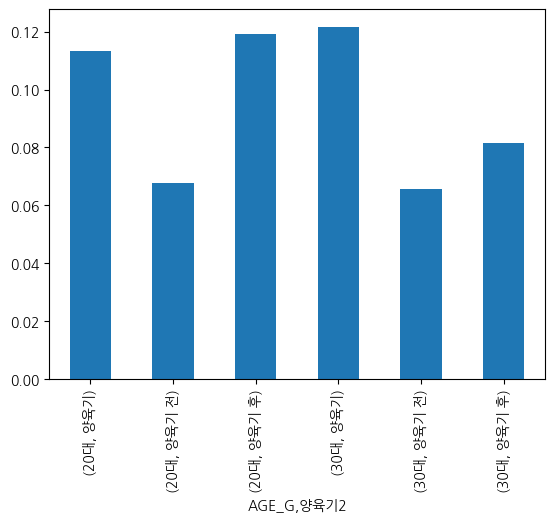

In [152]:
new_data_GDINS2.groupby(['AGE_G','양육기2'])['TERM/MAIN'].mean().plot.bar()

In [153]:
new_data_GDINS_해지2 = new_data_GDINS2[new_data_GDINS2['TERM/MAIN'] == 1]
new_data_GDINS_해지2['TERM/MAIN']

210       1
550       1
622       1
684       1
967       1
         ..
99576     1
99640     1
99983     1
100093    1
100134    1
Name: TERM/MAIN, Length: 843, dtype: int64

In [154]:
cross_tab = pd.crosstab(new_data_GDINS_해지2['AGE_G'], new_data_GDINS_해지2['양육기2'])
chi2, p, dof, expected = stats.chi2_contingency(cross_tab)# 결과 출력
print("Chi-square 통계량:", chi2)
print("p-값:", p)
print("자유도:", dof)
print("기대 빈도:", expected)

Chi-square 통계량: 15.882329878466573
p-값: 0.0003557917610124275
자유도: 2
기대 빈도: [[ 27.76749703  74.53380783   9.69869514]
 [181.23250297 486.46619217  63.30130486]]


/tmp/ipykernel_7944/704117491.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['CUST_JOB_INCM'].plot.bar()


<Axes: xlabel='AGE_G,양육기2'>

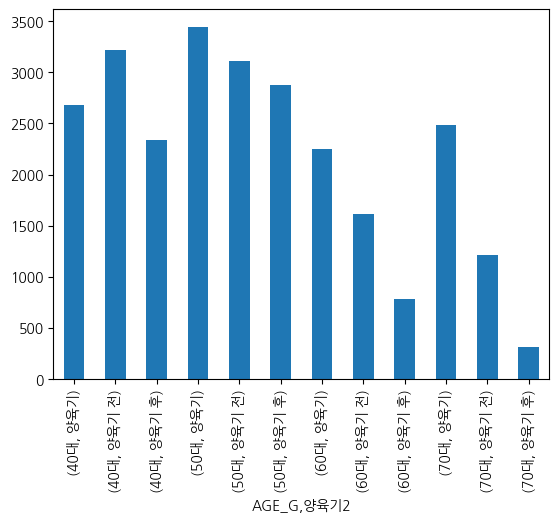

In [358]:
new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['CUST_JOB_INCM'].plot.bar()

In [156]:
# new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['TERM/MAIN'].plot.bar()

In [157]:
data_GDINS_2 = data_GDINS[data_GDINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]
data_GDINS_2['AGE_G']

0         50대
5         40대
9         40대
10        50대
11        40대
         ... 
100223    40대
100224    40대
100227    50대
100229    40대
100231    40대
Name: AGE_G, Length: 34801, dtype: object

In [158]:
data_GDINS_2after = data_GDINS_2[data_GDINS_2['양육기2'] == "양육기 후"]
data_GDINS_2after['CUST_JOB_INCM']

0         5400
10           0
26        8400
27        5900
30        5200
          ... 
100200       0
100208    5000
100211    3900
100218       0
100219       0
Name: CUST_JOB_INCM, Length: 14180, dtype: int64

In [159]:
data_GDINS_2before = data_GDINS_2[data_GDINS_2['양육기2'] != "양육기 후"]
data_GDINS_2before['CUST_JOB_INCM']

5         4400
9         4700
11           0
28           0
31        5800
          ... 
100223       0
100224    5800
100227    5000
100229    4600
100231    4200
Name: CUST_JOB_INCM, Length: 20621, dtype: int64

In [160]:

statistic, p = stats.shapiro(filtered_data['CUST_JOB_INCM'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.8459094762802124, p-value = 1.338833246622152e-16


In [161]:
# 만 위트니 U 검정 실행
u_stat, p_value = stats.mannwhitneyu(data_GDINS_2before['CUST_JOB_INCM'], data_GDINS_2after['CUST_JOB_INCM'], alternative='two-sided')
print("U-statistic:", u_stat)
print("p-value:", p_value)

U-statistic: 167408166.0
p-value: 8.572961277686295e-127


In [162]:
data_GDINS_2before['CUST_JOB_INCM']

5         4400
9         4700
11           0
28           0
31        5800
          ... 
100223       0
100224    5800
100227    5000
100229    4600
100231    4200
Name: CUST_JOB_INCM, Length: 20621, dtype: int64

- 대립가설 ==> 보장성 보험 가입 고객의 양육기 후와 전 집단간 추정소득의 평균의 차이는 존재한다,
- ==> 양육기 후 자녀는 독립하는 등 여러 이유로 부모가 소득이 많지 않아도 된다고 생각하기에 소득이 작아진다고 생각하였다.
- ==> 양육기 자녀를 가진 고객이 자녀가 양육기 후가 되기 전에 소득이 작아져도 미래를 보장할 수 있는 상품을 가입할 수 있도록 유도하는 것이 좋겠다!

/tmp/ipykernel_7944/1028389349.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['PREM_OVDU_RATE'].plot.bar()


<Axes: xlabel='AGE_G,양육기2'>

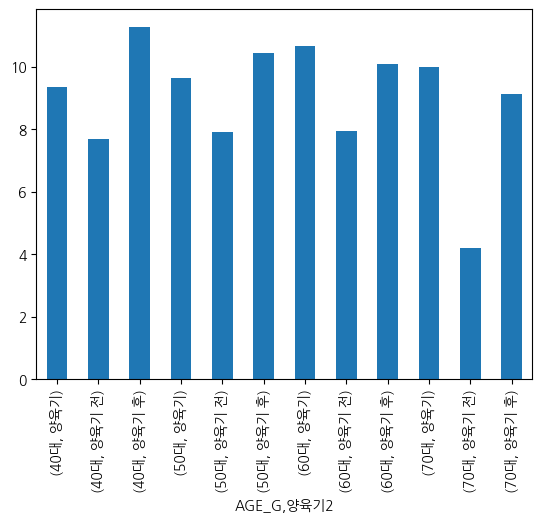

In [385]:
new_data_GDINS.groupby(['AGE_G','양육기2']).mean()['PREM_OVDU_RATE'].plot.bar()

In [386]:
data_GDINS_3 = data_GDINS[data_GDINS['AGE_G'].isin(['40대', '50대', '60대', '70대'])]
data_GDINS_3['AGE_G']

0         50대
5         40대
9         40대
10        50대
11        40대
         ... 
100223    40대
100224    40대
100227    50대
100229    40대
100231    40대
Name: AGE_G, Length: 34801, dtype: object

In [387]:
data_GDINS_3after = data_GDINS_3[data_GDINS_3['양육기2'] == "양육기"]
data_GDINS_3after['PREM_OVDU_RATE']

9         15
33         1
47        20
51        56
56        10
          ..
100180     2
100203     1
100223     0
100224     8
100229     5
Name: PREM_OVDU_RATE, Length: 7494, dtype: int64

In [388]:
data_GDINS_3before = data_GDINS_3[data_GDINS_3['양육기2'] != "양육기"]
data_GDINS_3before['PREM_OVDU_RATE']

0         12
5         25
10         1
11         0
26         1
          ..
100211    41
100218     5
100219     2
100227     0
100231     0
Name: PREM_OVDU_RATE, Length: 27307, dtype: int64

In [389]:
statistic, p = stats.shapiro(filtered_data['PREM_OVDU_RATE'])
print('statistic = {}, p-value = {}'.format(statistic, p))

statistic = 0.7603982090950012, p-value = 1.4436540892817908e-20


In [390]:
# 만 위트니 U 검정 실행
u_stat, p_value = stats.mannwhitneyu(data_GDINS_3before['PREM_OVDU_RATE'], data_GDINS_3after['PREM_OVDU_RATE'], alternative='two-sided')
print("U-statistic:", u_stat)
print("p-value:", p_value)

U-statistic: 96645086.5
p-value: 1.1995635503039758e-13


- 대립가설: 보장성 보험 가입자들 중 양육기 자녀에 따라 보험료연체율 평균의 차이가 존재한다.
- 양육기 자녀를 가진 가입자는 보험료연체율이 증가한다.
- 